In [1]:
import os

data_dir = "/kaggle/input/vehicle-detection-dataset"
print(os.listdir(data_dir))


['test1', 'train']


In [2]:
import os
import shutil
from pathlib import Path

# Paths
DATASET_READONLY = "/kaggle/input/vehicle-detection-dataset/train/Final Train Dataset"
WORKING_DIR = "/kaggle/working/vehicle_dataset"
Path(WORKING_DIR).mkdir(parents=True, exist_ok=True)

# Copy all files from read-only input dir to writable working dir
for file in os.listdir(DATASET_READONLY):
    src = os.path.join(DATASET_READONLY, file)
    dst = os.path.join(WORKING_DIR, file)
    if not os.path.exists(dst):
        shutil.copy2(src, dst)

# Now create labels folder inside working dir (writable)
OUT_LABEL_DIR = os.path.join(WORKING_DIR, "labels")
Path(OUT_LABEL_DIR).mkdir(parents=True, exist_ok=True)

print(f"Copied dataset to writable folder: {WORKING_DIR}")

Copied dataset to writable folder: /kaggle/working/vehicle_dataset


In [3]:
import os
import shutil
import random
from pathlib import Path
import xml.etree.ElementTree as ET

# Use the downloaded dataset path
DATASET_DIR = "/kaggle/working/vehicle_dataset"
OUT_LABEL_DIR = os.path.join(DATASET_DIR, "labels_cleaned")
Path(OUT_LABEL_DIR).mkdir(parents=True, exist_ok=True)

# Updated mapping: removed truck & van
map_to = {
    "car": "car", "suv": "car", "taxi": "car",
    "bus": "bus",
    "motorbike": "motorbike",
    "three wheelers (CNG)": "three_wheeler"
}

# Updated classes list
final_classes = ["car", "bus", "motorbike", "three_wheeler"]
class_to_id = {c: i for i, c in enumerate(final_classes)}

def convert(xml_path):
    try:
        tree = ET.parse(xml_path)
    except ET.ParseError as e:
        print(f"Parse error in file {xml_path}: {e}")
        return []
    
    root = tree.getroot()
    w = int(root.find("size/width").text)
    h = int(root.find("size/height").text)
    yolo_lines = []
    
    for obj in root.findall("object"):
        name = obj.find("name").text.strip()
        name = map_to.get(name)
        if name is None or name not in class_to_id:
            continue
        cls_id = class_to_id[name]
        b = obj.find("bndbox")
        xmin = float(b.find("xmin").text)
        ymin = float(b.find("ymin").text)
        xmax = float(b.find("xmax").text)
        ymax = float(b.find("ymax").text)

        xmin, ymin = max(0, xmin), max(0, ymin)
        xmax, ymax = min(w, xmax), min(h, ymax)
        if xmax <= xmin or ymax <= ymin:
            continue

        x_c = ((xmin + xmax) / 2.0) / w
        y_c = ((ymin + ymax) / 2.0) / h
        bw = (xmax - xmin) / w
        bh = (ymax - ymin) / h

        yolo_lines.append(f"{cls_id} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}")
    
    return yolo_lines


In [4]:
# Convert all XML annotation files to YOLO format
for file in os.listdir(DATASET_DIR):
    if not file.endswith(".xml"):
        continue
    xml_path = os.path.join(DATASET_DIR, file)
    lines = convert(xml_path)
    
    txt_name = os.path.splitext(file)[0] + ".txt"
    out_path = os.path.join(OUT_LABEL_DIR, txt_name)
    
    if lines:
        with open(out_path, "w") as f:
            f.write("\n".join(lines))
    else:
        # Create an empty label file if no objects matched
        open(out_path, "w").close()

print("✅ Conversion to YOLO format completed.")

Parse error in file /kaggle/working/vehicle_dataset/231.xml: syntax error: line 1, column 0
✅ Conversion to YOLO format completed.


In [5]:
import os, random, shutil
from pathlib import Path

OUT = "/kaggle/working/dataset_yolo"       
OUT_LABEL_CLEANED = "/kaggle/working/labels_cleaned"  

# Create dirs
Path(OUT_LABEL_CLEANED).mkdir(parents=True, exist_ok=True)
for folder in ["images/train", "images/val", "labels/train", "labels/val"]:
    Path(os.path.join(OUT, folder)).mkdir(parents=True, exist_ok=True)

# Convert XML → YOLO and save in labels_cleaned
for file in os.listdir(DATASET_DIR):
    if not file.endswith(".xml"):
        continue
    xml_path = os.path.join(DATASET_DIR, file)
    lines = convert(xml_path)  # your existing convert() function

    txt_name = os.path.splitext(file)[0] + ".txt"
    out_path = os.path.join(OUT_LABEL_CLEANED, txt_name)

    if lines:
        with open(out_path, "w") as f:
            f.write("\n".join(lines))
    else:
        open(out_path, "w").close()

print("✅ Conversion to YOLO format completed in labels_cleaned.")

# Split into train/val
images = [f for f in os.listdir(DATASET_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.seed(42)
random.shuffle(images)

split = int(len(images) * 0.8)
train_imgs = images[:split]
val_imgs = images[split:]

def copy_list(img_list, split_name):
    for img in img_list:
        base = os.path.splitext(img)[0]

        src_img = os.path.join(DATASET_DIR, img)
        src_lbl = os.path.join(OUT_LABEL_CLEANED, base + ".txt")

        dst_img = os.path.join(OUT, f"images/{split_name}", img)
        dst_lbl = os.path.join(OUT, f"labels/{split_name}", base + ".txt")

        shutil.copy2(src_img, dst_img)

        if os.path.exists(src_lbl):
            shutil.copy2(src_lbl, dst_lbl)
        else:
            open(dst_lbl, "w").close()

copy_list(train_imgs, "train")
copy_list(val_imgs, "val")

print(f"✅ Split done. Train: {len(train_imgs)} Val: {len(val_imgs)}")

Parse error in file /kaggle/working/vehicle_dataset/231.xml: syntax error: line 1, column 0
✅ Conversion to YOLO format completed in labels_cleaned.
✅ Split done. Train: 2402 Val: 601


In [6]:
dataset_yaml = f"""
train: {OUT}/images/train
val: {OUT}/images/val

nc: 4
names: ['car', 'bus', 'motorbike', 'three_wheeler']
"""

with open(f"{OUT}/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("dataset.yaml created.")

dataset.yaml created.


In [7]:
!pip install ultralytics --quiet

In [8]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data=f"{OUT}/dataset.yaml",
    epochs=100,
    imgsz=640,       # better accuracy
    batch=8,         # adjust based on GPU memory
    name="veh_exp_kaggle",
    val=True,
    augment=True     # enable augmentation
)

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset_yolo/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=veh_exp_kaggle2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

train: Scanning /kaggle/working/dataset_yolo/labels/train... 2402 images, 245 backgrounds, 0 corrupt: 100%|██████████| 2402/2402 [00:06<00:00, 369.83it/s] 

train: /kaggle/working/dataset_yolo/images/train/145.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_yolo/images/train/146.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_yolo/images/train/148.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_yolo/images/train/149.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_yolo/images/train/152.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_yolo/images/train/153.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_yolo/images/train/154.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_yolo/images/train/155.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_yolo/images/train/156.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_yolo/images/train/157.jpg: corrupt JPEG restored and saved
train: /kaggle/working/dataset_yolo/images/train/158.jpg: corrupt JPEG restored and saved
train: /ka

train: New cache created: /kaggle/working/dataset_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1211.9±1197.5 MB/s, size: 330.8 KB)


val: Scanning /kaggle/working/dataset_yolo/labels/val... 320 images, 34 backgrounds, 0 corrupt:  53%|█████▎    | 320/601 [00:02<00:02, 117.05it/s]


KeyboardInterrupt: 


image 1/601 /kaggle/working/dataset_yolo/images/val/08.jpg: 480x640 14 cars, 2 buss, 1 motorbike, 2 three_wheelers, 6.7ms
image 2/601 /kaggle/working/dataset_yolo/images/val/105.jpg: 640x480 3 cars, 1 bus, 7.5ms
image 3/601 /kaggle/working/dataset_yolo/images/val/107.jpg: 640x480 1 bus, 6.0ms
image 4/601 /kaggle/working/dataset_yolo/images/val/11.jpg: 640x480 4 cars, 1 bus, 2 three_wheelers, 6.8ms
image 5/601 /kaggle/working/dataset_yolo/images/val/111.jpg: 640x480 1 car, 1 bus, 5.8ms
image 6/601 /kaggle/working/dataset_yolo/images/val/114.jpg: 640x480 2 cars, 1 bus, 1 three_wheeler, 5.8ms
image 7/601 /kaggle/working/dataset_yolo/images/val/115.jpg: 640x480 3 cars, 1 bus, 2 motorbikes, 1 three_wheeler, 5.6ms
image 8/601 /kaggle/working/dataset_yolo/images/val/118.jpg: 640x480 2 cars, 1 bus, 3 motorbikes, 5.4ms
image 9/601 /kaggle/working/dataset_yolo/images/val/119.jpg: 640x384 2 cars, 3 buss, 1 three_wheeler, 7.9ms
image 10/601 /kaggle/working/dataset_yolo/images/val/12.jpg: 640x480 

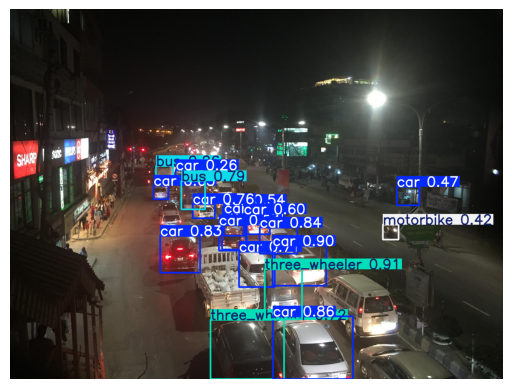

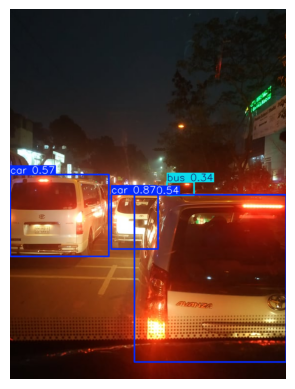

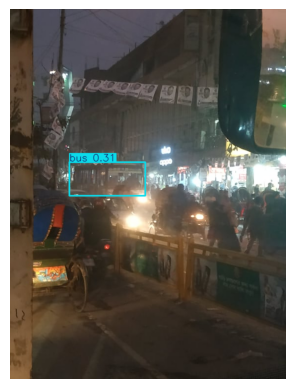

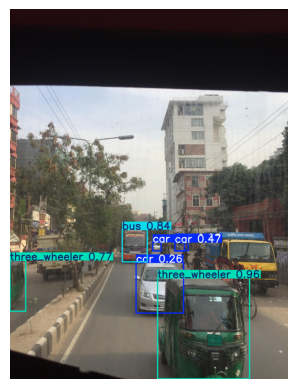

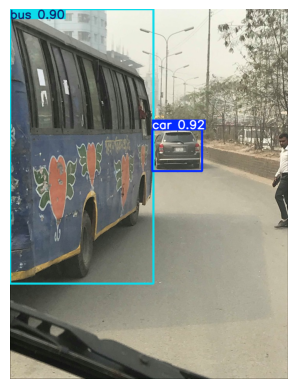

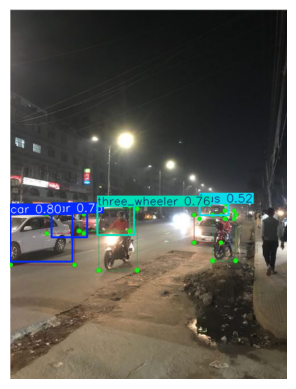

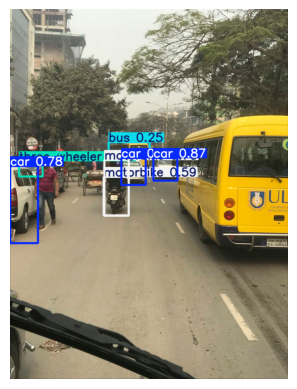

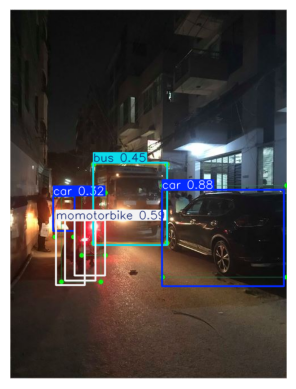

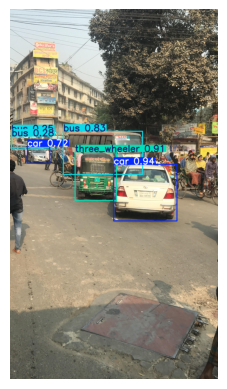

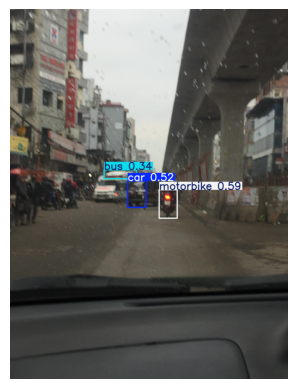

In [11]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load your trained model
model = YOLO("runs/detect/veh_exp_kaggle/weights/best.pt")  # path to your best.pt

# Predict on a sample image
results = model("/kaggle/working/dataset_yolo/images/val", save=True)  # save=True will store predictions in 'runs/detect/predict'

# Show image with detections
for r in results[0:10]:
    img = r.plot()  # draw boxes on image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


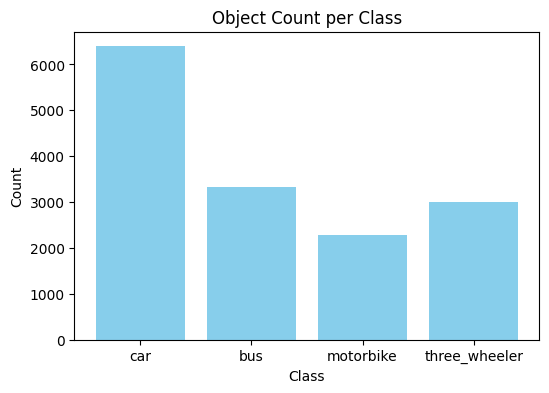

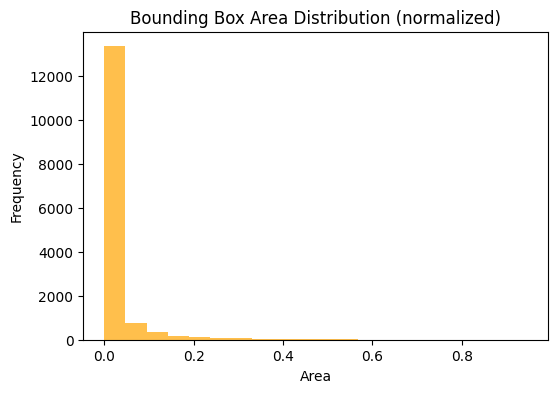

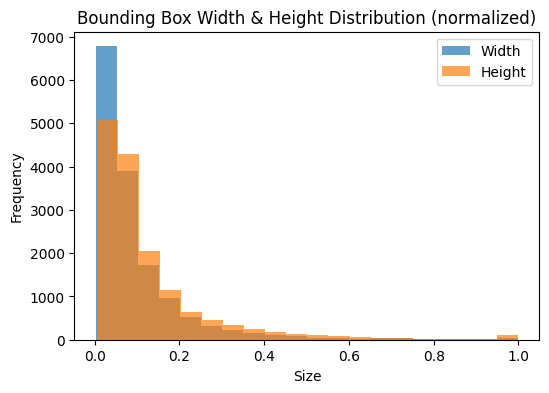

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

labels_dir = "/kaggle/working/vehicle_dataset/labels_cleaned"
# folder with YOLO .txt labels
classes = ["car", "bus", "motorbike", "three_wheeler"]  # your class names

obj_counts = {cls: 0 for cls in classes}
widths, heights, areas = [], [], []

for file in os.listdir(labels_dir):
    if file.endswith(".txt"):
        with open(os.path.join(labels_dir, file), "r") as f:
            for line in f:
                cls_id, x, y, w, h = map(float, line.strip().split())
                cls_name = classes[int(cls_id)]
                obj_counts[cls_name] += 1
                widths.append(w)
                heights.append(h)
                areas.append(w * h)

# Plot class distribution
plt.figure(figsize=(6,4))
plt.bar(obj_counts.keys(), obj_counts.values(), color='skyblue')
plt.title("Object Count per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Plot area distribution
plt.figure(figsize=(6,4))
plt.hist(areas, bins=20, color='orange', alpha=0.7)
plt.title("Bounding Box Area Distribution (normalized)")
plt.xlabel("Area")
plt.ylabel("Frequency")
plt.show()

# Width & Height distribution
plt.figure(figsize=(6,4))
plt.hist(widths, bins=20, alpha=0.7, label='Width')
plt.hist(heights, bins=20, alpha=0.7, label='Height')
plt.title("Bounding Box Width & Height Distribution (normalized)")
plt.xlabel("Size")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1940.9±728.6 MB/s, size: 141.1 KB)


val: Scanning /kaggle/working/dataset_yolo/labels/val.cache... 601 images, 64 backgrounds, 0 corrupt: 100%|██████████| 601/601 [00:00<?, ?it/s]

val: /kaggle/working/dataset_yolo/images/val/144.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_yolo/images/val/147.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_yolo/images/val/150.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_yolo/images/val/151.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_yolo/images/val/163.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_yolo/images/val/165.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_yolo/images/val/169.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_yolo/images/val/173.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_yolo/images/val/174.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_yolo/images/val/175.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_yolo/images/val/180.jpg: corrupt JPEG restored and saved
val: /kaggle/working/dataset_yolo/images/val/182.jpg: 


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        601       2918      0.753      0.653      0.705      0.453
                   car        333       1259      0.734      0.701      0.747      0.505
                   bus        313        640      0.758      0.677      0.737      0.515
             motorbike        242        449      0.752      0.541      0.584      0.293
         three_wheeler        231        570      0.767      0.694      0.751      0.499
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val2
Precision: 0.7527833355145743
Recall: 0.6533307583433414
mAP50: 0.7048155507578489
mAP50-95: 0.45304494401708323


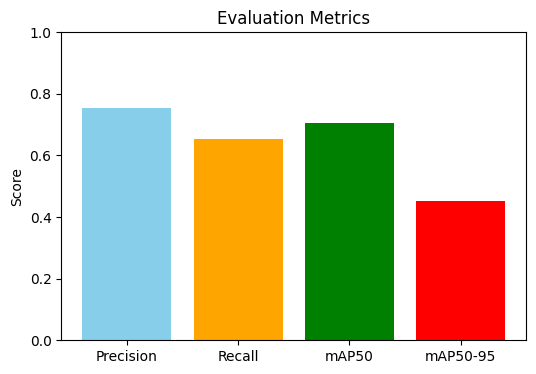

In [16]:
import pandas as pd 
metrics = model.val()  # returns ultralytics.utils.metrics.DetMetrics object

# Convert metrics to dictionary
metrics_dict = metrics.results_dict

# Display metrics
print("Precision:", metrics_dict['metrics/precision(B)'])
print("Recall:", metrics_dict['metrics/recall(B)'])
print("mAP50:", metrics_dict['metrics/mAP50(B)'])
print("mAP50-95:", metrics_dict['metrics/mAP50-95(B)'])

# Convert to DataFrame for easier plotting
df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'mAP50', 'mAP50-95'],
    'Value': [
        metrics_dict['metrics/precision(B)'],
        metrics_dict['metrics/recall(B)'],
        metrics_dict['metrics/mAP50(B)'],
        metrics_dict['metrics/mAP50-95(B)']
    ]
})

# Plot bar chart
plt.figure(figsize=(6,4))
plt.bar(df['Metric'], df['Value'], color=['skyblue', 'orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.show()